In [5]:
!pip -qq install -U xformers --index-url https://download.pytorch.org/whl/cu118
!pip -qq install bert-score openpyxl gspread_pandas langchain qdrant-client wikipedia https://github.com/vllm-project/vllm/releases/download/v0.2.2/vllm-0.2.2+cu118-cp310-cp310-manylinux1_x86_64.whl

In [6]:
import pandas as pd
##Load data vào dataframe
df = pd.read_excel('NTTU_DATA.xlsx')  

In [7]:
df.head()

,Question,Answer
0,Thời gian đào tạo được quy định như thế nào t...,Thời gian đào tạo được quy định bởi kế hoạch h...
1,Thời gian theo kế hoạch học tập chuẩn toàn khó...,Thời gian theo kế hoạch học tập chuẩn toàn khó...
2,Sinh viên có được phép dừng học trong quá trì...,Sinh viên được phép dừng học trong quá trình đ...
3,Thời gian tối đa để sinh viên hoàn thành khóa ...,Thời gian tối đa để sinh viên hoàn thành khóa...
4,Có được phép hoàn thành chương trình đào tạo s...,"Có, sinh viên được phép hoàn thành chương trìn..."


In [8]:
GENERATE_MODEL_NAME="vilm/vietcuna-7b-v3"
EMBEDDINGS_MODEL_NAME="sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
QDRANT_URL = "<QDRANT_URL>"
QDRANT_COLLECTION_NAME = "nttu_sotay_vector_db_v1"
NGROK_STATIC_DOMAIN = "<NGROK_STATIC_DOMAIN>"
NGROK_TOKEN=          "<NGROK_TOKEN>"
HUGGINGFACE_API_KEY = "<HUGGINGFACE_API_KEY>"
QDRANT_API_KEY =      "<QDRANT_API_KEY>"

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_rerank = AutoModelForSequenceClassification.from_pretrained('amberoad/bert-multilingual-passage-reranking-msmarco').to(device)
tokenizer_rerank = AutoTokenizer.from_pretrained('amberoad/bert-multilingual-passage-reranking-msmarco')

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
from langchain.schema.document import Document
from langchain_core.vectorstores import VectorStoreRetriever
from langchain.retrievers import WikipediaRetriever
from typing import List
class RerankRetriever(VectorStoreRetriever):
    vectorstore: VectorStoreRetriever
    def get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.vectorstore.get_relevant_documents(query=query)
        candidates = [doc.page_content for doc in docs]
        queries = [query]*len(candidates)
        features = tokenizer_rerank(queries, candidates,  padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            scores = model_rerank(**features).logits
            values, indices = torch.sum(scores, dim=1).sort()
            relevant_docs = docs[indices[0]]
        return [relevant_docs]
class RerankWikiRetriever(VectorStoreRetriever):
    vectorstore: WikipediaRetriever
    def get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.vectorstore.get_relevant_documents(query=query)
        candidates = [doc.page_content for doc in docs]
        queries = [query]*len(candidates)
        features = tokenizer_rerank(queries, candidates,  padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            scores = model_rerank(**features).logits
            values, indices = torch.sum(scores, dim=1).sort()
            relevant_docs = docs[indices[0]]
        return [relevant_docs]

In [11]:
from langchain.retrievers import WikipediaRetriever
from langchain.vectorstores import Qdrant
from langchain.llms import HuggingFacePipeline
from qdrant_client import QdrantClient
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain.chains import RetrievalQA,MultiRetrievalQAChain
from langchain.llms import VLLM
from langchain.llms import HuggingFaceHub

class LLMServe:
    def __init__(self) -> None:
      self.embeddings = self.load_embeddings()
      self.current_source = "wiki"
      self.retriever = self.load_retriever(retriever_name = self.current_source,embeddings=self.embeddings)
      self.pipe = self.load_model_pipeline(max_new_tokens=300)
      self.prompt = self.load_prompt_template()
      self.rag_pipeline = self.load_rag_pipeline(llm=self.pipe,
                                            retriever=self.retriever,
                                            prompt=self.prompt)
    def load_embeddings(self):
      embeddings = HuggingFaceInferenceAPIEmbeddings(
          model_name=EMBEDDINGS_MODEL_NAME,
          api_key = HUGGINGFACE_API_KEY,
          model_kwargs = {'device': "auto"}
      )
      return embeddings

    def load_retriever(self,retriever_name,embeddings):
      retriever=None
      if retriever_name == "wiki":
        retriever = RerankWikiRetriever(vectorstore = WikipediaRetriever(lang="vi",
                                       doc_content_chars_max=800,top_k_results=15))
      else:
        client = QdrantClient(
            url=QDRANT_URL,api_key=QDRANT_API_KEY, prefer_grpc=False
        )
        db = Qdrant(client=client,
                    embeddings=embeddings,
                    collection_name=QDRANT_COLLECTION_NAME)
        retriever = RerankRetriever(vectorstore = db.as_retriever(search_kwargs={"k":15}))

      return retriever

    def load_model_pipeline(self,max_new_tokens=100):
      llm = VLLM(
          model=GENERATE_MODEL_NAME,
          trust_remote_code=True,
          max_new_tokens=max_new_tokens,
          top_k=10,
          top_p=0.95,
          temperature=0.4,
          dtype="half",
          # vllm_kwargs={"quantization": "awq"}
      )
      return llm

    def load_prompt_template(self):
      # query_template = "Bạn là một trợ lý của trường Đại học Nguyễn Tất Thành. Hãy trả lời câu hỏi sau dựa trên ngữ cảnh, nếu ngữ cảnh không cung cấp câu trả lời hoặc không chắc chắn hãy trả lời 'Tôi không biết thông tin này, tuy nhiên đoạn thông tin dưới phần tham khảo có thể có câu trả lời cho bạn!' đừng cố tạo ra câu trả lời không có trong ngữ cảnh.\nNgữ cảnh: {context} \nCâu hỏi: {question}\nTrả lời: "
      # query_template = "Tham khảo ngữ cảnh:{context}\n\n### Câu hỏi:{question}\n\n### Trả lời:"
      query_template = "Bạn là một chatbot thông minh trả lời câu hỏi dựa trên ngữ cảnh (context).\n\n### Context:{context} \n\n### Human: {question}\n\n### Assistant:"
      prompt = PromptTemplate(template=query_template,
                        input_variables= ["context","question"])
      return prompt

    def load_rag_pipeline(self,llm,retriever,prompt):
      rag_pipeline = RetrievalQA.from_chain_type(
      llm=llm, chain_type='stuff',
      retriever=retriever,
      chain_type_kwargs={
      "prompt": prompt
      },
      return_source_documents=True)
      return rag_pipeline

    def rag(self,source):
      if source == self.current_source:
        return self.rag_pipeline
      else:
        self.retriever = self.load_retriever(retriever_name=source,embeddings=self.embeddings)
        self.rag_pipeline = self.load_rag_pipeline(llm=self.pipe,
                                      retriever=self.retriever,
                                      prompt=self.prompt)
        self.current_source = source
        return self.rag_pipeline

In [12]:
app = LLMServe()

config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

WARNING 12-05 11:26:06 config.py:398] Casting torch.bfloat16 to torch.float16.
INFO 12-05 11:26:06 llm_engine.py:72] Initializing an LLM engine with config: model='vilm/vietcuna-7b-v3', tokenizer='vilm/vietcuna-7b-v3', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=None, seed=0)


tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

INFO 12-05 11:27:32 llm_engine.py:207] # GPU blocks: 3481, # CPU blocks: 546


In [13]:
qa_chain = app.rag(source="nttu")

In [14]:
eval_questions = df["Question"].values

eval_answers = df["Answer"].values

examples = [
    {"query": q, "ground_truths": [eval_answers[i]]}
    for i, q in enumerate(eval_questions)
]

In [15]:
predictions=[]
data_size = len(examples)
for i in range(data_size):
  print("Processing...("+str(i)+"/"+str(data_size)+")")
  predictions += [qa_chain(examples[i])]


Processing...(0/145)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Processing...(1/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Processing...(2/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


Processing...(3/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Processing...(4/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Processing...(5/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


Processing...(6/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Processing...(7/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Processing...(8/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Processing...(9/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Processing...(10/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Processing...(11/145)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


Processing...(12/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Processing...(13/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


Processing...(14/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


Processing...(15/145)


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


Processing...(16/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Processing...(17/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Processing...(18/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Processing...(19/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Processing...(20/145)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


Processing...(21/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.18s/it]


Processing...(22/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Processing...(23/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.10s/it]


Processing...(24/145)


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


Processing...(25/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


Processing...(26/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


Processing...(27/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Processing...(28/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


Processing...(29/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


Processing...(30/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Processing...(31/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Processing...(32/145)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


Processing...(33/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Processing...(34/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Processing...(35/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.99s/it]


Processing...(36/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Processing...(37/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.45s/it]


Processing...(38/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


Processing...(39/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Processing...(40/145)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


Processing...(41/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Processing...(42/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


Processing...(43/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


Processing...(44/145)


Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


Processing...(45/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.36s/it]


Processing...(46/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Processing...(47/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Processing...(48/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Processing...(49/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Processing...(50/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Processing...(51/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Processing...(52/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Processing...(53/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Processing...(54/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Processing...(55/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Processing...(56/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Processing...(57/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


Processing...(58/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Processing...(59/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Processing...(60/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


Processing...(61/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Processing...(62/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Processing...(63/145)


Processed prompts: 100%|██████████| 1/1 [00:09<00:00,  9.50s/it]


Processing...(64/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Processing...(65/145)


Processed prompts: 100%|██████████| 1/1 [00:14<00:00, 14.08s/it]


Processing...(66/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Processing...(67/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Processing...(68/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Processing...(69/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Processing...(70/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Processing...(71/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Processing...(72/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Processing...(73/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Processing...(74/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Processing...(75/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


Processing...(76/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Processing...(77/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


Processing...(78/145)


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


Processing...(79/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Processing...(80/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Processing...(81/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Processing...(82/145)


Processed prompts: 100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


Processing...(83/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Processing...(84/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Processing...(85/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Processing...(86/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Processing...(87/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Processing...(88/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


Processing...(89/145)


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


Processing...(90/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Processing...(91/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Processing...(92/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


Processing...(93/145)


Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


Processing...(94/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


Processing...(95/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Processing...(96/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Processing...(97/145)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


Processing...(98/145)


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Processing...(99/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Processing...(100/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


Processing...(101/145)


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


Processing...(102/145)


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


Processing...(103/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Processing...(104/145)


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


Processing...(105/145)


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


Processing...(106/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.31s/it]


Processing...(107/145)


Processed prompts: 100%|██████████| 1/1 [00:14<00:00, 14.02s/it]


Processing...(108/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]


Processing...(109/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


Processing...(110/145)


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


Processing...(111/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Processing...(112/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


Processing...(113/145)


Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


Processing...(114/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Processing...(115/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Processing...(116/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


Processing...(117/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Processing...(118/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Processing...(119/145)


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.15s/it]


Processing...(120/145)


Processed prompts: 100%|██████████| 1/1 [00:13<00:00, 13.02s/it]


Processing...(121/145)


Processed prompts: 100%|██████████| 1/1 [00:09<00:00,  9.82s/it]


Processing...(122/145)


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]


Processing...(123/145)


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Processing...(124/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Processing...(125/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Processing...(126/145)


Processed prompts: 100%|██████████| 1/1 [00:17<00:00, 17.59s/it]


Processing...(127/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


Processing...(128/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Processing...(129/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Processing...(130/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Processing...(131/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Processing...(132/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Processing...(133/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Processing...(134/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Processing...(135/145)


Processed prompts: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Processing...(136/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Processing...(137/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Processing...(138/145)


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Processing...(139/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Processing...(140/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Processing...(141/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Processing...(142/145)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Processing...(143/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Processing...(144/145)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [16]:
for i in range(len(predictions)):
  predictions[i]["source_documents"] = predictions[i]["source_documents"][0].page_content

In [17]:
import json
# Lưu lại kết quả chạy
with open("predictions_vietcuna-7b-v3.json", "w") as outfile:
    json.dump(predictions, outfile)

In [18]:
from bert_score import score

# Example texts
candidates = [x["result"] for x in predictions]
references = [x["ground_truths"][0] for x in predictions]

# Calculate BERTScore
P, R, F1 = score(candidates, references, lang='vi', verbose=True)

# Print scores
print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 1.38 seconds, 105.29 sentences/sec
Precision: 0.729580283164978
Recall: 0.7872748970985413
F1 Score: 0.7554426193237305


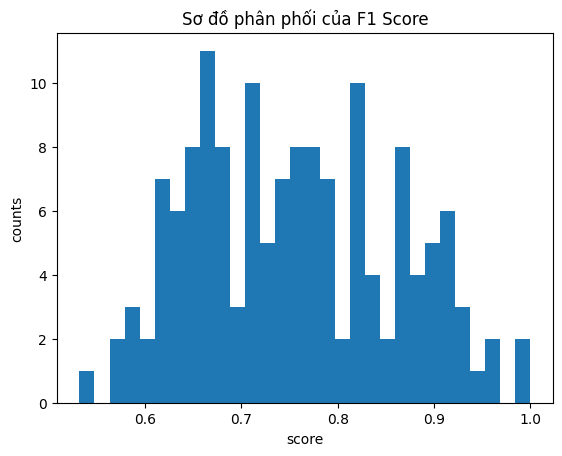

In [19]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=30)
plt.xlabel("score")
plt.ylabel("counts")
plt.title("Sơ đồ phân phối của F1 Score")
plt.show()

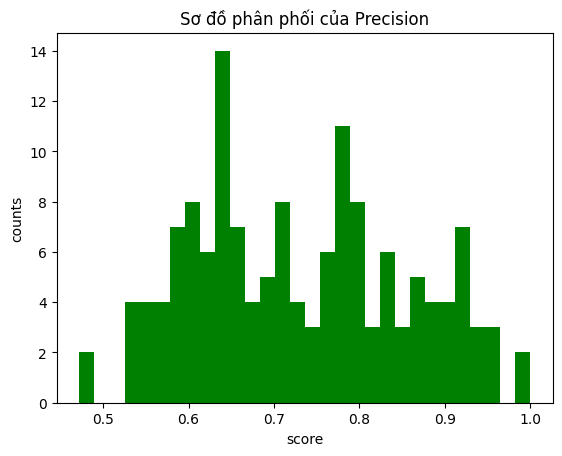

In [20]:
import matplotlib.pyplot as plt
plt.hist(P, bins=30,color="green")
plt.xlabel("score")
plt.ylabel("counts")
plt.title("Sơ đồ phân phối của Precision")
plt.show()

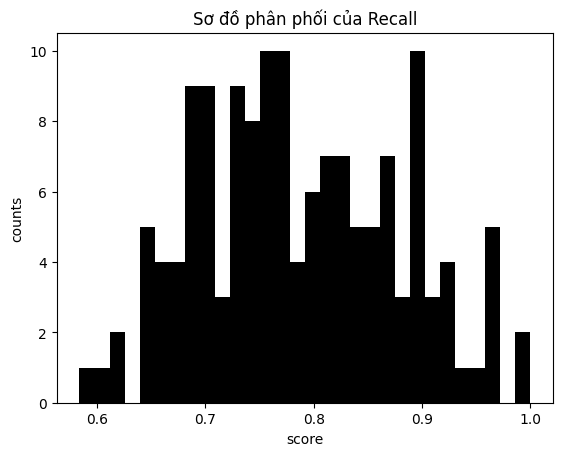

In [21]:
import matplotlib.pyplot as plt
plt.hist(R, bins=30,color="black")
plt.xlabel("score")
plt.ylabel("counts")
plt.title("Sơ đồ phân phối của Recall")
plt.show()